In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import math
from scipy.interpolate import interp1d
import seaborn as sns
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.mlab import griddata
from datetime import datetime
from scipy import stats

# Load parameter distributions -- F04

In [2]:
μ1 = 1/21 #14 days infectious
μ2 = 1/5 #5 days (14 - 9 days)
σ =1/5 #5 days exposed
ω=1/9 # 9 days until emitted to hospital
capT = 10000
γ = 1/(80*365)
Input_H = [1500,0,0,0]
parameters = [Input_H, capT]

In [3]:
# θ = np.load('ABC/theta_SEIR.npy')
# tols = np.load('ABC/tols_SEIR.npy')
θ = np.load('ABC/ABC_season/theta_Season_F10.npy')
# θ = np.load('ABC/ABC_season/theta_Season_F04_2.npy')
# θ = np.load('ABC/theta_F_combined1.npy')
# tols = np.load('ABC/tols_F_combined1.npy')
a_β, loc_β, scale_β = stats.gamma.fit(θ[5][:,0])
a_ϵ, loc_ϵ, scale_ϵ = stats.gamma.fit(θ[5][:,1])
a_σ, loc_σ, scale_σ = stats.gamma.fit([1/a for a in θ[5][:,2]])
a_μ1, loc_μ1, scale_μ1 = stats.gamma.fit([1/a for a in θ[5][:,3]])
a_μ2, loc_μ2, scale_μ2 = stats.gamma.fit([1/a for a in θ[5][:,4]])

# Use SEIR model -- split up rate from human to human and external

In [4]:
def gillespieSEIR_season(initial, beta, mu1,mu2, sigma,epsilon):
    event_time = []
    pop = []
    N = sum(initial)
    pop.append(initial)
    event_time.append(0)
    times = 0
    ind = 0
    year = 1
    cuminf = []
    cuminf.append(0)
    events = []
    num_external= 0
    num_internal = 0
    Rtotal = 1
    death = 0
    while Rtotal>0:
#         print(Rtotal)
        state = np.zeros(shape= (4,12))
        
        ############################### Seasonality #######################################
        if np.round(times)%365 <= 120:
            E = epsilon
        else:
            E = 0
        ####################################################################################
        #################################### EVENTS ########################################
        ####################################################################################    
        
        R_external = E*pop[ind][0]
        state[:,0] = [-1,1,0,0]
        
        R_se = beta*(pop[ind][0])*(pop[ind][2])/N  
        state[:,1] = [-1, 1, 0, 0]
        
        R_ei = sigma*pop[ind][1]
        state[:,2] = [0, -1, 1, 0]
        

        
        R_ir = mu2*pop[ind][2]
        state[:,3] = [0,0,-1,1]
        

        R_is = mu1*pop[ind][2]
        state[:,4] = [1,0,-1,0]
        

########################## RATES ##############################
        rate = [R_external, R_se, R_ei,  R_ir,  R_is]
#                 , R_sb, R_sd, R_ed, R_id]

        Rtotal = sum(rate)

        delta_t= -np.log(np.random.uniform(0,1))/Rtotal
        P = np.random.uniform(0,1)*Rtotal
        
        if Rtotal>0:
            times =times+ delta_t
            event = np.min(np.where(P<=np.cumsum(rate)))
            events.append(event)
            event_time.append(times)
            pop.append(pop[ind]+state[:,event])
#             print(cuminf)
            if event == 0:
                num_external +=1
            if event == 1:
                num_internal +=1
            if event == 3:
                death +=1 
            if event == 2:
                cuminf.append(1 +cuminf[ind] )
            else:
                cuminf.append(0 +cuminf[ind])
            ind=ind+1
#         print(pop[ind])
        N = sum(pop[ind][:2])
    return event_time, np.array(pop), events, cuminf, num_external, num_internal, death

In [5]:
external = []
internal = []
total = []
death = []
for k in range(5000):
    beta = stats.gamma.rvs( a_β, loc_β, scale_β)
    mu1 = 1/stats.gamma.rvs( a_μ1, loc_μ1, scale_μ1)
    mu2 = 1/stats.gamma.rvs( a_μ2, loc_μ2, scale_μ2)
    epsilon = stats.gamma.rvs( a_ϵ, loc_ϵ, scale_ϵ)
    sigma = 1/stats.gamma.rvs( a_σ, loc_σ, scale_σ)
    M=gillespieSEIR_season(parameters[0], beta, mu1,mu2,
                          sigma,epsilon)
    external.append(M[4])
    internal.append(M[5])
    total.append(M[3][-1])
    death.append(M[6])

/home/emma/.local/lib/python3.5/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in double_scalars


In [6]:
# external

In [7]:
np.mean([death[a]/total[a] for a in range(len(death))])

0.16538020300618805

In [8]:
print('percent external forcing', 100*np.mean([external[a]/total[a] for a in range(len(external))]),'%')
print('percent human to human', 100*np.mean([internal[a]/total[a] for a in range(len(internal))]),'%')

percent external forcing 97.09037819379118 %
percent human to human 2.9096218062088153 %


{'boxes': [<matplotlib.lines.Line2D at 0x7f239acedd30>],
 'caps': [<matplotlib.lines.Line2D at 0x7f239acf4780>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f239acf9438>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f239acf4fd0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f239acede80>,
  <matplotlib.lines.Line2D at 0x7f239acf4358>]}

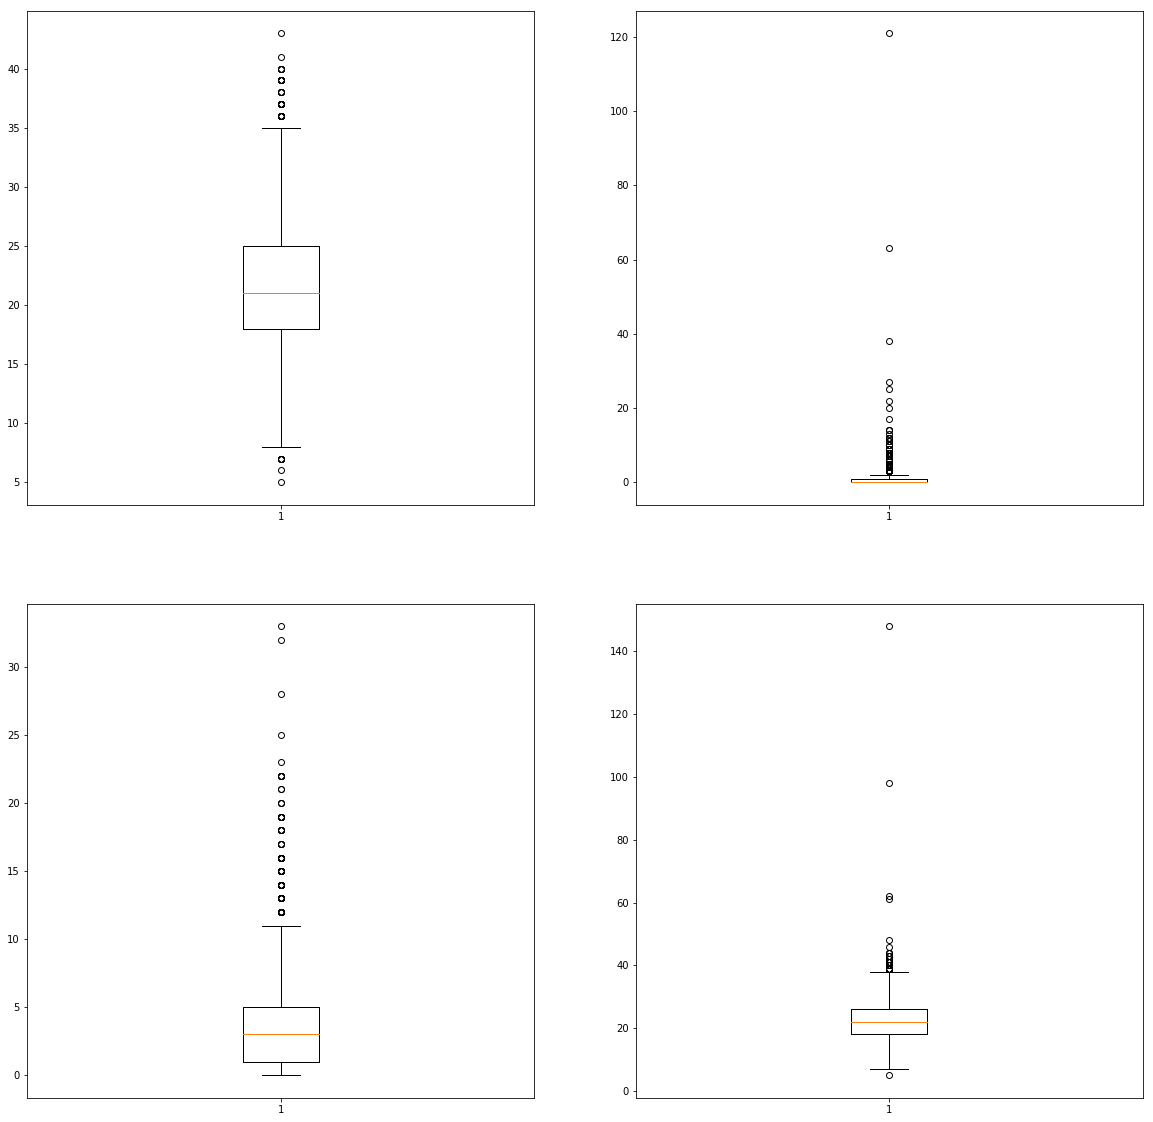

In [9]:
plt.figure(figsize = (20,20))
plt.subplot(2,2,1)
# plt.boxplot([external[a]/total[a] for a in range(len(external))])
plt.boxplot(external)

plt.subplot(2,2,2)
# plt.boxplot([internal[a]/total[a] for a in range(len(internal))])
plt.boxplot(internal)

plt.subplot(2,2,3)
# plt.boxplot([death[a]/total[a] for a in range(len(death))])
plt.boxplot(death)
plt.subplot(2,2,4)
plt.boxplot(total)

In [33]:
R_0_H = (β*σ)/((σ+μ)*(μ1+μ2+μ)) 
R_0_H

0.0050101135956061756

# Number of Exposed

In [12]:
def SEIRexposed(initial, beta, mu1,mu2, sigma,epsilon):
    event_time = []
    pop = []
    N = sum(initial)
    pop.append(initial)
    event_time.append(0)
    times = 0
    ind = 0
    year = 1
    cuminf = []
    cuminf.append(0)
    events = []
    num_external= 0
    num_internal = 0
    exposed = 0
    Rtotal = 1
    death = 0
    while pop[ind][2]<1:
#         print(Rtotal)
        state = np.zeros(shape= (4,12))
        
        ############################### Seasonality #######################################
        if np.round(times)%365 <= 120:
            E = epsilon
        else:
            E = 0
        ####################################################################################
        #################################### EVENTS ########################################
        ####################################################################################    
        
        R_external = E*pop[ind][0]
        state[:,0] = [-1,1,0,0]
        
        R_se = beta*(pop[ind][0])*(pop[ind][2])/N  
        state[:,1] = [-1, 1, 0, 0]
        
        R_ei = sigma*pop[ind][1]
        state[:,2] = [0, -1, 1, 0]
        

        
        R_ir = mu2*pop[ind][2]
        state[:,3] = [0,0,-1,1]
        

        R_is = mu1*pop[ind][2]
        state[:,4] = [1,0,-1,0]
        

########################## RATES ##############################
        rate = [R_external, R_se, R_ei,  R_ir,  R_is]
#                 , R_sb, R_sd, R_ed, R_id]

        Rtotal = sum(rate)

        delta_t= -np.log(np.random.uniform(0,1))/Rtotal
        P = np.random.uniform(0,1)*Rtotal
        
        if Rtotal>0:
            times =times+ delta_t
            event = np.min(np.where(P<=np.cumsum(rate)))
            events.append(event)
            event_time.append(times)
            pop.append(pop[ind]+state[:,event])
#             print(cuminf)
            if event == 0:
                num_external +=1
                exposed +=1 
            if event == 1:
                num_internal +=1
                exposed +=1
            if event == 3:
                death +=1 
            if event == 2:
                cuminf.append(1 +cuminf[ind] )
            else:
                cuminf.append(0 +cuminf[ind])
            ind=ind+1
#         print(pop[ind])
        N = sum(pop[ind][:2])
    return event_time, np.array(pop), events, cuminf, num_external, num_internal, death, exposed

In [13]:
external = []
internal = []
total = []
death = []
exposed = []
for k in range(5000):
    beta = stats.gamma.rvs( a_β, loc_β, scale_β)
    mu1 = 1/stats.gamma.rvs( a_μ1, loc_μ1, scale_μ1)
    mu2 = 1/stats.gamma.rvs( a_μ2, loc_μ2, scale_μ2)
    epsilon = stats.gamma.rvs( a_ϵ, loc_ϵ, scale_ϵ)
    sigma = 1/stats.gamma.rvs( a_σ, loc_σ, scale_σ)
    M=SEIRexposed(parameters[0], beta, mu1,mu2,
                          sigma,epsilon)
    external.append(M[4])
    internal.append(M[5])
    total.append(M[3][-1])
    death.append(M[6])
    exposed.append(M[7])

2

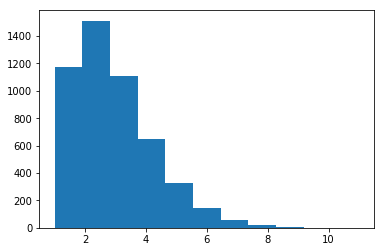

In [15]:
plt.hist(exposed, bins = np.max(exposed))
stats.mode(exposed)[0][0]

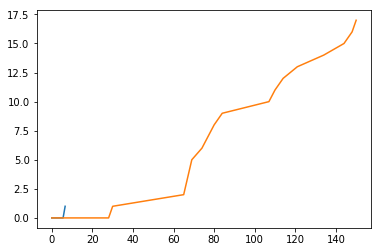

In [32]:

Data_F04=pd.read_csv("Case_data/2010_faridpur_cases.csv",sep = ',', header = 0)
############################# Spacing ##############################################
date_format = "%d/%m/%y"


def Spacing(dataset):
    record = []
    record.append(datetime.strptime(dataset['Date'][0], date_format).day)
    for i in range(1, len(dataset)):
        record.append(record[i-1]+(datetime.strptime(dataset['Date'][i], date_format)-datetime.strptime(dataset['Date'][i-1], date_format)).days)
    start_day = (datetime.strptime(Data_F04['Date'].values[0], date_format)-datetime.strptime('01/11/09', date_format)).days
    record = [int(a - record[0]) for a in record]
    record = [int(a +start_day) for a in record]

    return record

Rec_F04=Spacing(Data_F04)
Cum_F04 = Data_F04['CumsumInf'].values
leng = len(np.arange(0, Rec_F04[0], 2))
Rec_F04 = np.insert(Rec_F04, 0, np.arange(0, Rec_F04[0], 2))
Cum_F04 = np.insert(Cum_F04, 0, np.zeros(leng))
summary = np.array([Rec_F04, Cum_F04])
plt.plot(M[0], M[3]
        )
plt.plot(summary[0], summary[1])
# plt.xlim([0,20])

In [29]:
ξ

NameError: name 'ξ' is not defined